In [16]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timeit

In [17]:
# Set up the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [18]:
# For CIFAR use this cell
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                          shuffle=True, num_workers=2)


#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=200,
#                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [19]:
# For Tiny imagenet use this cell
num_classes = 200 # Change to 5 or 200 to use tiny-imagenet-5 or tiny-imagenet-200
data_dir = "./data/tiny-imagenet-%d" % num_classes

data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    'val': transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

trainset = torchvision.datasets.ImageFolder(data_dir+'/train/', data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(data_dir+'/val/', data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ["dont know" for i in range(num_classes)] # Filler because you don't have the class array

dont know dont know


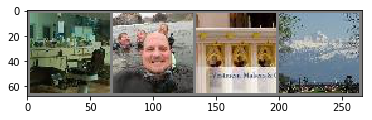

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [21]:
def conv1x1(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=0)

def conv1x1T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose2d(x, K, stride=1, padding=0)

def conv3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=1)

def conv3x3T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose2d(x, K, stride=1, padding=1)


def gradient(I,h):
    Iy = 1/h*(I[:,:,:,1:] - I[:,:,:,0:-1])
    Ix = 1/h*(I[:,:,1:,:] - I[:,:,0:-1,:])
    return Ix, Iy

def divergence(Ix,Iy,h):
    n = Ix.shape
    Ixx = torch.zeros(n[0],n[1],n[2]+1,n[3],device=Ix.device)
    Iyy = torch.zeros(n[0],n[1],n[2]+1,n[3],device=Iy.device)
    
    Iyy[:,:,:,1:-1] = 1/h*(Iy[:,:,:,1:] - Iy[:,:,:,0:-1])
    Ixx[:,:,1:-1,:] = 1/h*(Ix[:,:,1:,:] - Ix[:,:,0:-1,:])
    return Ixx + Iyy

def edge2Cell(Ix,Iy):
    I1 = torch.zeros(n[0],n[1],n[2]+1,n[3],device=Ix.device)
    I2 = torch.zeros(n[0],n[1],n[2]+1,n[3],device=Ix.device) 
    I2[:,:,:,1:-1] = 0.5*(Iy[:,:,:,1:] + Iy[:,:,:,0:-1])
    I1[:,:,1:-1,:] = 0.5*(Ix[:,:,1:,:] + Ix[:,:,0:-1,:])
    I2[:,:,:,0]  = Iy[:,:,:,0]
    I2[:,:,:,-1] = Iy[:,:,:,-1]
    I1[:,:,0,:]  = Iy[:,:,0,:]
    I1[:,:,-1,:] = Iy[:,:,-1,:]
    
    return I1, I2

def convDiag(x,K):
    n = K.shape
    return F.conv2d(x, K, stride=1, padding=1, groups=n[0])


def smooth(x):
    nchan = x.shape[1]
    Ki    = torch.zeros((1,1,3,3)) 
    Ki[0,0,:,:] = torch.tensor(0.125*[[0, 1, 0],[1, 4, 1],[0,1,0]])
    K = torch.zeros((nchan,1,3,3))
    for i in range(nchan):
        K[i,0,:,:] = Ki
    
    z = convDiag(x,K)
    return z,K


dis = nn.CrossEntropyLoss()
def misfit(X,W,C):
    n = W.shape
    X = X.view(-1,n[0])
    S = torch.matmul(X,W)
    return dis(S,C), S   

def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

In [22]:
class ResNetGrad(nn.Module):

    def __init__(self, h,dt,NG):
        super().__init__()

        # network geometry
        self.NG       = NG
        # space-time step
        self.h        = h
        self.dt       = dt
        
        # coarsening and TV norm
        #self.coarsen  = nn.AvgPool2d(32)
        self.coarsen2 = nn.AvgPool2d(2)
        
        
    def forward(self,I,Kresnet):
    
        nt = len(Kresnet)
        dt = self.dt
        h  = self.h
        # time stepping
        for j in range(nt):
            
            # First case - rsent style step
            if NG[0,j] == NG[1,j]: 
 
                # Compute gradients
                Ix, Iy = gradient(I,self.h)
        
                # apply convolution
                zx  = conv1x1(Ix, Kresnet[j])
                zy  = conv1x1(Iy, Kresnet[j])
                zx  = conv1x1T(zx,Kresnet[j])
                zy  = conv1x1T(zy,Kresnet[j])
            
                
                zx  = F.instance_norm(zx)
                zy  = F.instance_norm(zy)
                
                zx  = F.relu(zx)
                zy  = F.relu(zy)
                
                #zx  = conv1x1T(zx,Kresnet[j])
                #zy  = conv1x1T(zy,Kresnet[j])
                
                z  = divergence(zx,zy,self.h)
               
                tmp  = I
                I    = 2*I  - Iold + (self.dt**2)*z
                Iold = tmp
            # Change number of channels/resolution    
            else:
                z  = conv3x3(I, Kresnet[j])
                z  = F.instance_norm(z)
                I  = F.relu(z)
                if NG[2,j] == 1:
                    I = self.coarsen2(I)
                Iold = 0.0
             
        return I 

In [23]:
# SRQ 223 842
# initialize net and weights
h           = 1e-1
dt          = 1e-1

# Network geometry
NG = [3,  64, 64, 64, 64, 64,  128, 128, 128,   128,  128,
      64, 64, 64, 64, 64, 128, 128, 128, 128,   128,  256,
      0,   0,  0,  0,  0,  1,    0,   0,   0,     0,    1]

NG = np.reshape(NG,(3,-1))
net   = ResNetGrad(h,dt,NG)

nsteps = NG.shape[1]


Kresnet = []
for i in range(nsteps):  
    if NG[0,i] == NG[1,i]:
        #Ki  = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),1,1))
        #stdv  = 1e-3
        #Ki.data.uniform_(-stdv, stdv)
        Ki  = nn.Parameter(torch.zeros(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),1,1))
    else:
        Ki = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]) ,3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
    
    Kresnet.append(Ki)
    # Move to the GPU
    Ki.data = Ki.data.to(device)



In [24]:
# run the network
images, labels = images.to(device), labels.to(device)
net.to(device)

x = net(images,Kresnet)

torch.Size([4, 256, 16, 16])

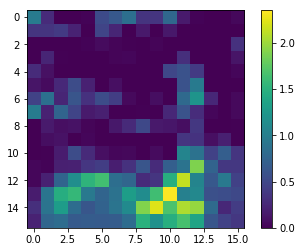

In [25]:
plt.imshow(x.detach()[1,5,:,:])
plt.colorbar()
x.shape

In [26]:
# weights for linear classifier 
n = x.shape
W     = nn.Parameter(torch.Tensor(n[1]*n[2]*n[3],200))
stdv  = 1e-3
W.data.uniform_(-stdv, stdv)
    
# Move to GPU
W.data = W.data.to(device)

In [27]:
C = torch.randint(0,200,(4,),dtype=torch.long)
C = C.to(device)
loss,_ = misfit(x,W,C)
print(loss)    


tensor(5.2289, device='cuda:0')


In [28]:
np.log(200)

5.298317366548036

In [29]:
import torch.optim as optim
optimizer = optim.SGD([{'params':Kresnet},{'params': W}], lr=1e-4, momentum=0)


In [30]:
hist  = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,Kresnet)
        
        loss, Si = misfit(x,W,labels)
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        n_print = 100
        if i % n_print == n_print-1:    # print every 2000 mini-batches
            # compute validation accuracy
            with torch.no_grad():
                #for data in testloader:
                dataiter = iter(testloader)
                imagesV, labelsV = dataiter.next()
                imagesV, labelsV = imagesV.to(device), labelsV.to(device)
                xV = net(imagesV,Kresnet)
                lossV, SiV = misfit(xV,W,labelsV)
                accuracyV  = getAccuracy(SiV,labelsV)

            
            print('[%d, %5d]  %.3f  %.3f  %.3f' %
                  (epoch + 1, i + 1, running_loss / n_print, running_accuracy/n_print, accuracyV))
            hist.append([running_loss / n_print, running_accuracy/n_print, accuracyV])
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524549877902\work\aten\src\thc\generic/THCStorage.cu:58